## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'blue'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")

Name the notebook:
blue_wavelet_full_agriVision.ipynb


In [3]:
DATA_NAME='-'.join(path_list)

In [4]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = True
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/agriVision/full/wavelet/blue'

In [5]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [6]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::1000] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 9000,
 3: 36000,
 4: 144000,
 5: 576000,
 6: 2304000,
 7: 9216000,
 8: 36864000,
 9: 147456000,
 10: 589824000}

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamm

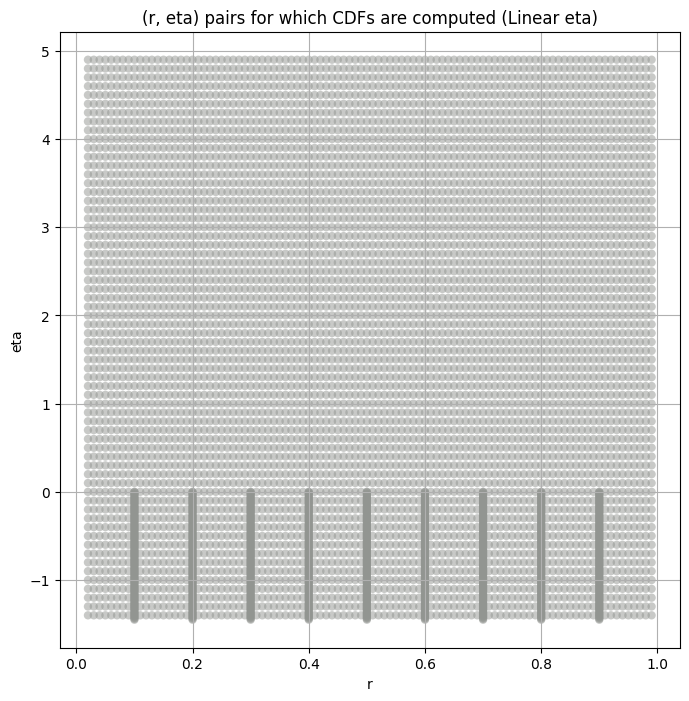

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, -1.4), <scipy.interpolate._fitpack2.In...",0.02,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,9.618487e+69,1.391529e+25
1,"((0.02, -1.3), <scipy.interpolate._fitpack2.In...",0.02,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.821735e+74,8.172634e+21
2,"((0.02, -1.2), <scipy.interpolate._fitpack2.In...",0.02,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.455488e+78,4.131785e+19
3,"((0.02, -1.1), <scipy.interpolate._fitpack2.In...",0.02,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.406735e+81,6.947275e+17
4,"((0.02, -1.0), <scipy.interpolate._fitpack2.In...",0.02,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.331443e+83,2.562075e+16


In [30]:
#warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [31]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [32]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if False or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,188570.730000,99638.340000,330262.220000,536.03296,113.304540,760.94360,9000.0
3,42568.312000,23773.760000,71607.330000,488.99530,135.974520,891.27313,36000.0
4,10773.336000,5322.670000,20877.791000,785.24280,131.392270,1768.95340,144000.0
5,1800.434900,923.853000,3624.655000,858.03740,109.913740,2074.88330,576000.0
6,390.887500,183.288650,971.469850,1521.53970,104.035530,3444.52950,2304000.0
7,98.479220,41.024357,351.604030,3306.70500,84.348870,5672.12000,9216000.0
8,33.173733,15.926921,100.374084,2264.61400,78.321760,4638.63770,36864000.0
9,11.252635,4.427865,43.877705,5137.09860,82.329865,6105.37160,147456000.0
10,1.875914,0.615992,10.184826,9775.98100,78.684250,7496.85840,589824000.0


## Initial Grid Search and Hypothesis Test Plots

In [49]:
EXCLUDE_CUTOFFS = [0, 10, 50, 100, 200, 300, 400, 600, 800]
SCALE_CAP = 1e5

In [50]:
augmented_obs_var_df = var_kurt_df[['obs_var']].copy()
augmented_obs_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))
    augmented_obs_var_df[f"exclude_{val}"] = temp_arr

augmented_obs_var_df

,obs_var,exclude_0,exclude_10,exclude_50,exclude_100,exclude_200,exclude_300,exclude_400,exclude_600,exclude_800
layer,,,,,,,,,,
2,188570.730000,188570.734375,67817.093750,45081.785156,36420.285156,26366.972656,20511.724609,16658.740234,11631.736328,8490.324219
3,42568.312000,42568.312500,24702.410156,14721.261719,12236.730469,9663.358398,8160.319824,7121.162598,5762.069824,4843.210938
4,10773.336000,10773.335938,7406.921875,4464.237793,3574.999512,2816.859863,2443.711670,2194.888672,1844.867676,1606.964844
5,1800.434900,1800.434937,1223.395020,795.382263,642.706543,515.472717,446.199188,398.910187,335.866638,293.843628
6,390.887500,390.887512,239.428009,158.687836,129.362122,104.113617,91.054344,82.370354,70.963371,63.420555
7,98.479220,98.479218,53.020332,35.698841,29.994589,25.205553,22.697041,21.009548,18.732716,17.162039
8,33.173733,33.173733,20.213518,13.967173,11.896943,10.253603,9.387711,8.784658,7.931215,7.318185
9,11.252635,11.252635,5.670156,3.848108,3.280626,2.824955,2.573658,2.395398,2.141654,1.959540
10,1.875914,1.875914,0.787507,0.543280,0.463169,0.395412,0.357785,0.331123,0.293203,0.266093


In [51]:
all_cdfs = {x[0]: x[1] for x in all_cdfs_df[(all_cdfs_df["r"] < 1) & (all_cdfs_df["eta"] < 5)]["(r,eta),cdf"]}
all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamm

####
Layer  2


  0%|          | 0/7460 [00:00<?, ?it/s]

100%|██████████| 7460/7460 [00:02<00:00, 2549.23it/s]


Finding Minimum after computing 7460 CDFs
2 0 0.024065082317001163 188570.73


100%|██████████| 7460/7460 [00:02<00:00, 2844.12it/s]


Finding Minimum after computing 7460 CDFs
2 10 0.01569720807719066 67817.09


100%|██████████| 7460/7460 [00:02<00:00, 2916.77it/s]


Finding Minimum after computing 7460 CDFs
2 50 0.014755807792932951 45081.785


100%|██████████| 7460/7460 [00:02<00:00, 2896.17it/s]


Finding Minimum after computing 7460 CDFs
2 100 0.017662363126010217 36420.285


100%|██████████| 7460/7460 [00:02<00:00, 2786.68it/s]


Finding Minimum after computing 7460 CDFs
2 200 0.02995203607026986 26366.973


100%|██████████| 7460/7460 [00:02<00:00, 2903.10it/s]


Finding Minimum after computing 7460 CDFs
2 300 0.04150443166711843 20511.725


100%|██████████| 7460/7460 [00:02<00:00, 2857.37it/s]


Finding Minimum after computing 7460 CDFs
2 400 0.05278118029022805 16658.74


100%|██████████| 7460/7460 [00:02<00:00, 2896.29it/s]


Finding Minimum after computing 7460 CDFs
2 600 0.07237891791817785 11631.736


100%|██████████| 7460/7460 [00:02<00:00, 2855.56it/s]


Finding Minimum after computing 7460 CDFs
2 800 0.09259559102728798 8490.324
Number of samples: 9000, Without approximation : 9000.0


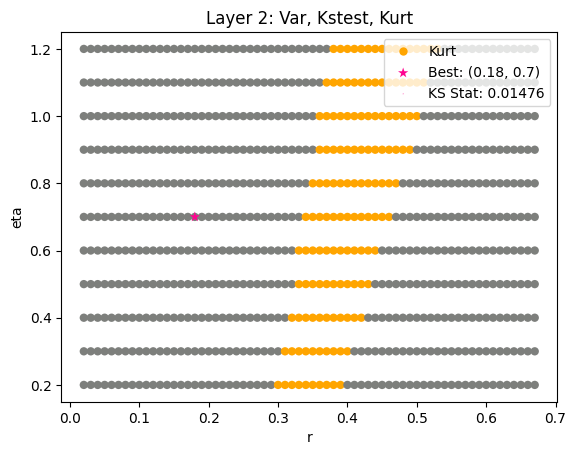

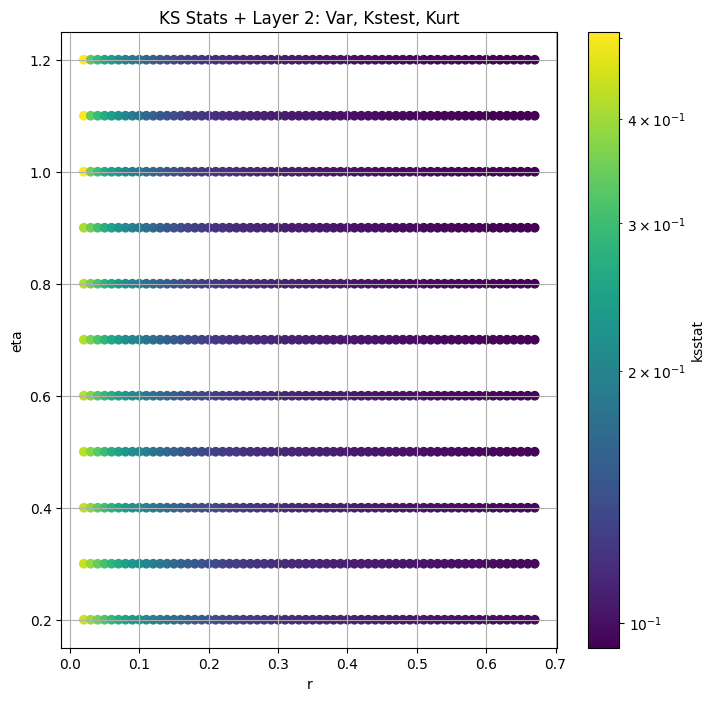

####
Layer  3


100%|██████████| 7460/7460 [00:09<00:00, 777.58it/s]


Finding Minimum after computing 7460 CDFs
3 0 0.02591192062126721 42568.312


100%|██████████| 7460/7460 [00:09<00:00, 770.57it/s]


Finding Minimum after computing 7460 CDFs
3 10 0.01895694293707753 24702.41


100%|██████████| 7460/7460 [00:09<00:00, 784.00it/s]


Finding Minimum after computing 7460 CDFs
3 50 0.014578485853438461 14721.262


100%|██████████| 7460/7460 [00:09<00:00, 780.97it/s]


Finding Minimum after computing 7460 CDFs
3 100 0.013647110935017137 12236.73


100%|██████████| 7460/7460 [00:09<00:00, 749.01it/s]


Finding Minimum after computing 7460 CDFs
3 200 0.012922924743000053 9663.358


100%|██████████| 7460/7460 [00:09<00:00, 783.92it/s]


Finding Minimum after computing 7460 CDFs
3 300 0.014458325320286625 8160.32


100%|██████████| 7460/7460 [00:09<00:00, 785.53it/s]


Finding Minimum after computing 7460 CDFs
3 400 0.016232754004216088 7121.1626


100%|██████████| 7460/7460 [00:09<00:00, 783.95it/s]


Finding Minimum after computing 7460 CDFs
3 600 0.02205337322343459 5762.07


100%|██████████| 7460/7460 [00:09<00:00, 779.14it/s]


Finding Minimum after computing 7460 CDFs
3 800 0.027638092402759162 4843.211
Number of samples: 36000, Without approximation : 36000.0


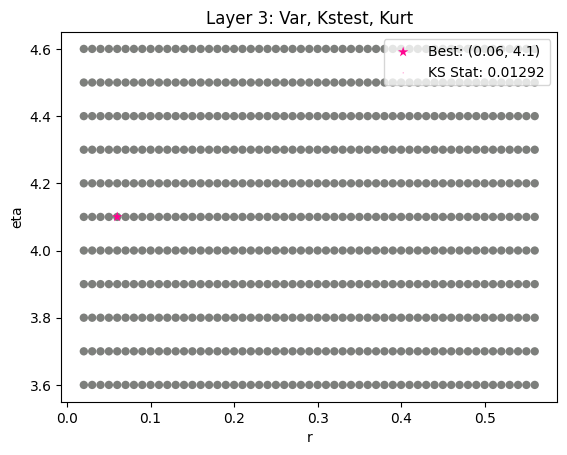

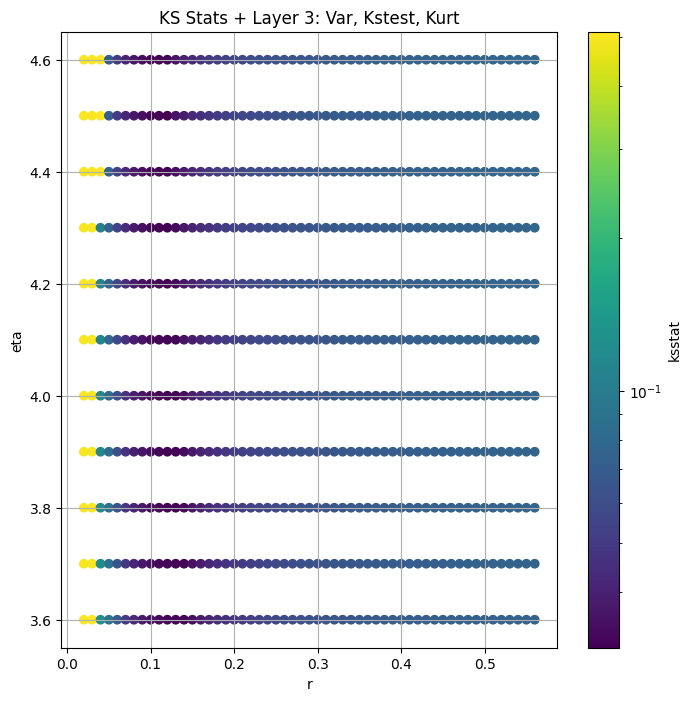

####
Layer  4


100%|██████████| 7460/7460 [00:30<00:00, 247.99it/s]


Finding Minimum after computing 7460 CDFs
4 0 0.02866491212943023 10773.336


100%|██████████| 7460/7460 [00:25<00:00, 297.77it/s]


Finding Minimum after computing 7460 CDFs
4 10 0.022588236068169842 7406.922


100%|██████████| 7460/7460 [00:29<00:00, 255.93it/s]


Finding Minimum after computing 7460 CDFs
4 50 0.015643832730302565 4464.238


100%|██████████| 7460/7460 [00:25<00:00, 294.76it/s]


Finding Minimum after computing 7460 CDFs
4 100 0.01288981316703941 3574.9995


100%|██████████| 7460/7460 [00:24<00:00, 299.39it/s]


Finding Minimum after computing 7460 CDFs
4 200 0.01010819040291655 2816.8599


100%|██████████| 7460/7460 [00:24<00:00, 302.95it/s]


Finding Minimum after computing 7460 CDFs
4 300 0.00794988490137552 2443.7117


100%|██████████| 7460/7460 [00:24<00:00, 303.31it/s]


Finding Minimum after computing 7460 CDFs
4 400 0.007910398876501135 2194.8887


100%|██████████| 7460/7460 [00:24<00:00, 301.78it/s]


Finding Minimum after computing 7460 CDFs
4 600 0.009855422707485961 1844.8677


100%|██████████| 7460/7460 [00:25<00:00, 288.95it/s]


Finding Minimum after computing 7460 CDFs
4 800 0.01185803518443529 1606.9648
Number of samples: 100000, Without approximation : 144000.0


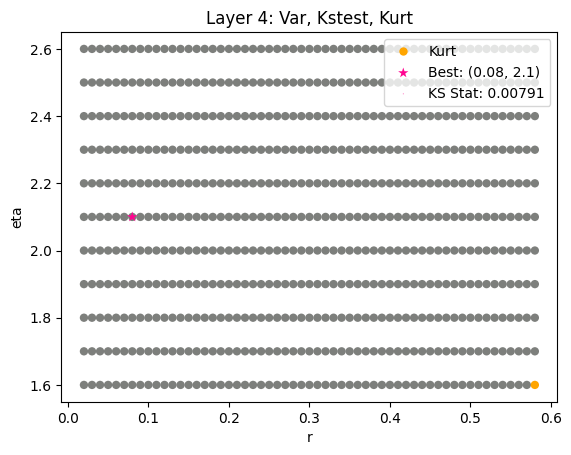

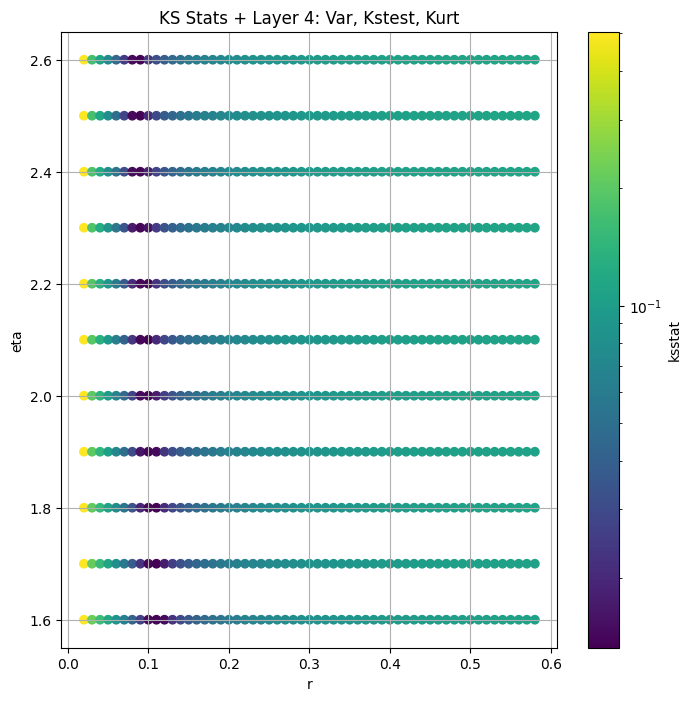

####
Layer  5


100%|██████████| 7460/7460 [00:26<00:00, 279.40it/s]


Finding Minimum after computing 7460 CDFs
5 0 0.025972857078906064 1800.4349


100%|██████████| 7460/7460 [00:24<00:00, 301.81it/s]


Finding Minimum after computing 7460 CDFs
5 10 0.021590519598930352 1223.395


100%|██████████| 7460/7460 [00:27<00:00, 273.89it/s]


Finding Minimum after computing 7460 CDFs
5 50 0.014691047530205267 795.38226


100%|██████████| 7460/7460 [00:25<00:00, 291.66it/s]


Finding Minimum after computing 7460 CDFs
5 100 0.01097952806904394 642.70654


100%|██████████| 7460/7460 [00:25<00:00, 295.41it/s]


Finding Minimum after computing 7460 CDFs
5 200 0.007486586538149015 515.4727


100%|██████████| 7460/7460 [00:25<00:00, 296.05it/s]


Finding Minimum after computing 7460 CDFs
5 300 0.005897046840239284 446.1992


100%|██████████| 7460/7460 [00:25<00:00, 295.75it/s]


Finding Minimum after computing 7460 CDFs
5 400 0.0070086059392518996 398.9102


100%|██████████| 7460/7460 [00:25<00:00, 296.19it/s]


Finding Minimum after computing 7460 CDFs
5 600 0.009206963646458677 335.86664


100%|██████████| 7460/7460 [00:25<00:00, 295.30it/s]


Finding Minimum after computing 7460 CDFs
5 800 0.01134014272547823 293.84363
Number of samples: 100000, Without approximation : 576000.0


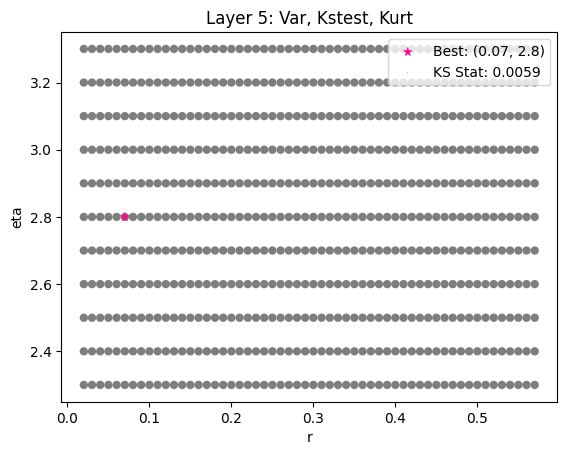

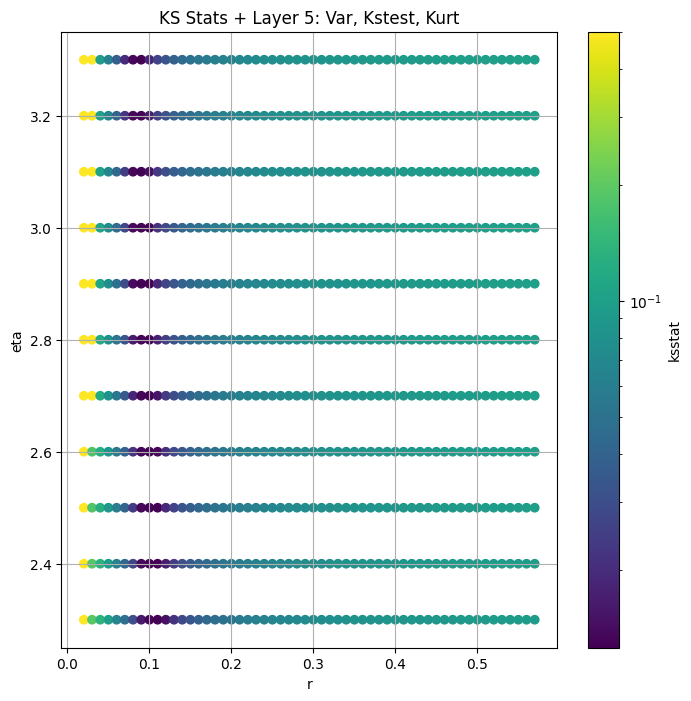

####
Layer  6


100%|██████████| 7460/7460 [00:25<00:00, 294.62it/s]


Finding Minimum after computing 7460 CDFs
6 0 0.027878517092720864 390.8875


100%|██████████| 7460/7460 [00:25<00:00, 288.96it/s]


Finding Minimum after computing 7460 CDFs
6 10 0.020525904143279927 239.42801


100%|██████████| 7460/7460 [00:25<00:00, 291.76it/s]


Finding Minimum after computing 7460 CDFs
6 50 0.013004379158550822 158.68784


100%|██████████| 7460/7460 [00:24<00:00, 300.67it/s]


Finding Minimum after computing 7460 CDFs
6 100 0.009393652550666126 129.36212


100%|██████████| 7460/7460 [00:28<00:00, 263.90it/s]


Finding Minimum after computing 7460 CDFs
6 200 0.004941458684610253 104.11362


100%|██████████| 7460/7460 [00:27<00:00, 275.78it/s]


Finding Minimum after computing 7460 CDFs
6 300 0.004706824930265863 91.054344


100%|██████████| 7460/7460 [00:25<00:00, 288.97it/s]


Finding Minimum after computing 7460 CDFs
6 400 0.0059272386603888005 82.37035


100%|██████████| 7460/7460 [00:24<00:00, 299.16it/s]


Finding Minimum after computing 7460 CDFs
6 600 0.008267943333916561 70.96337


100%|██████████| 7460/7460 [00:26<00:00, 283.72it/s]


Finding Minimum after computing 7460 CDFs
6 800 0.010492368865389401 63.420555
Number of samples: 100000, Without approximation : 2304000.0


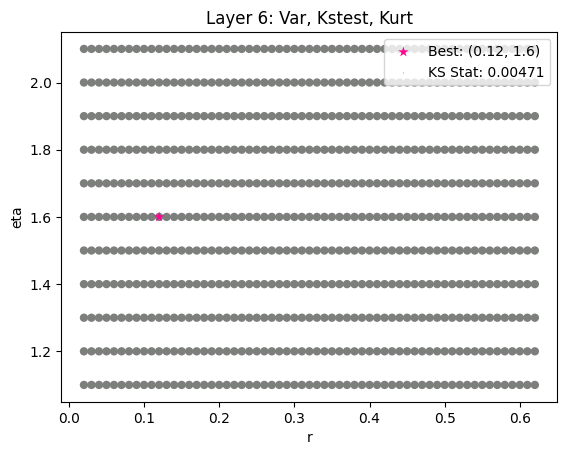

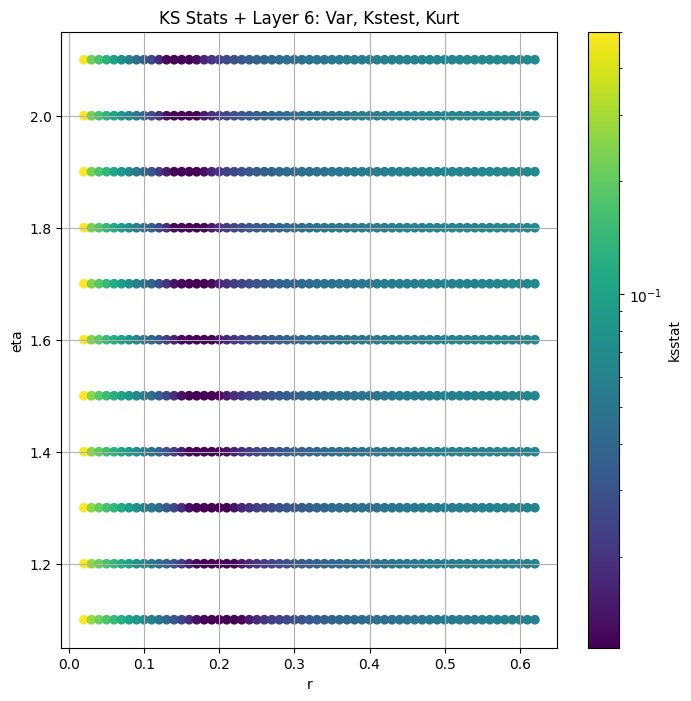

####
Layer  7


100%|██████████| 7460/7460 [00:26<00:00, 279.91it/s]


Finding Minimum after computing 7460 CDFs
7 0 0.028445411542838972 98.47922


100%|██████████| 7460/7460 [00:25<00:00, 295.26it/s]


Finding Minimum after computing 7460 CDFs
7 10 0.01754004962998068 53.020332


100%|██████████| 7460/7460 [00:25<00:00, 295.53it/s]


Finding Minimum after computing 7460 CDFs
7 50 0.00946852148844346 35.69884


100%|██████████| 7460/7460 [00:25<00:00, 296.19it/s]


Finding Minimum after computing 7460 CDFs
7 100 0.005807608763557126 29.994589


100%|██████████| 7460/7460 [00:25<00:00, 290.86it/s]


Finding Minimum after computing 7460 CDFs
7 200 0.0038122530809918675 25.205553


100%|██████████| 7460/7460 [00:25<00:00, 293.69it/s]


Finding Minimum after computing 7460 CDFs
7 300 0.004331850572723783 22.69704


100%|██████████| 7460/7460 [00:28<00:00, 266.14it/s]


Finding Minimum after computing 7460 CDFs
7 400 0.005562891846252471 21.009548


100%|██████████| 7460/7460 [00:25<00:00, 293.79it/s]


Finding Minimum after computing 7460 CDFs
7 600 0.007946584659983102 18.732716


100%|██████████| 7460/7460 [00:25<00:00, 297.14it/s]


Finding Minimum after computing 7460 CDFs
7 800 0.010224629161279863 17.162039
Number of samples: 100000, Without approximation : 9216000.0


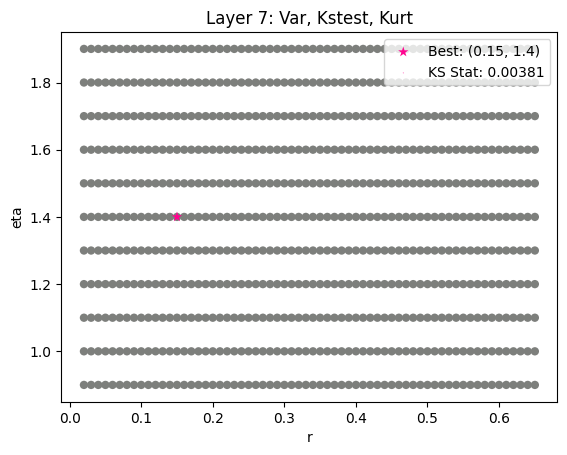

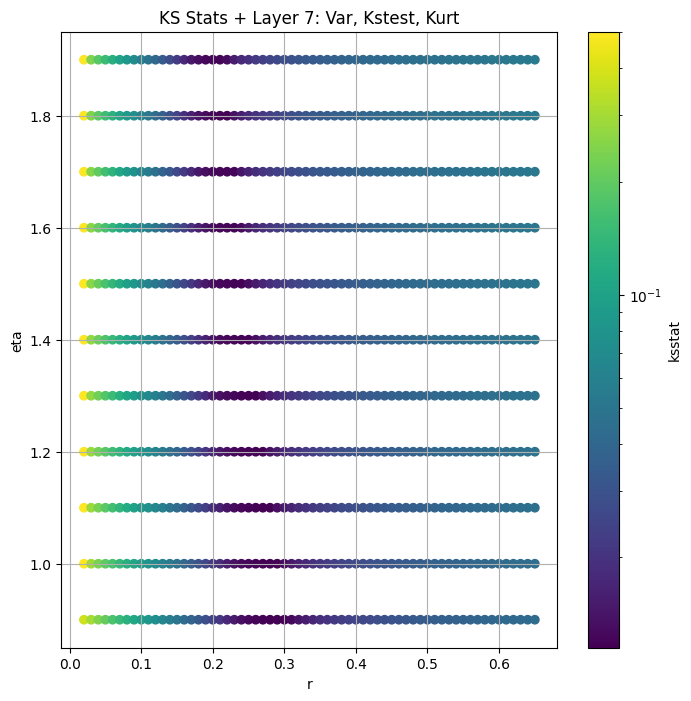

####
Layer  8


100%|██████████| 7460/7460 [00:27<00:00, 274.54it/s]


Finding Minimum after computing 7460 CDFs
8 0 0.021400611142691706 33.173733


100%|██████████| 7460/7460 [00:27<00:00, 271.95it/s]


Finding Minimum after computing 7460 CDFs
8 10 0.01299741018024464 20.213518


100%|██████████| 7460/7460 [00:25<00:00, 293.66it/s]


Finding Minimum after computing 7460 CDFs
8 50 0.004869978490105176 13.967173


100%|██████████| 7460/7460 [00:26<00:00, 283.34it/s]


Finding Minimum after computing 7460 CDFs
8 100 0.0033499999999965224 11.896943


100%|██████████| 7460/7460 [00:25<00:00, 295.75it/s]


Finding Minimum after computing 7460 CDFs
8 200 0.0033499999999965224 10.253603


100%|██████████| 7460/7460 [00:25<00:00, 290.25it/s]


Finding Minimum after computing 7460 CDFs
8 300 0.004225855126023026 9.387711


100%|██████████| 7460/7460 [00:25<00:00, 288.51it/s]


Finding Minimum after computing 7460 CDFs
8 400 0.005587456702228821 8.784658


100%|██████████| 7460/7460 [00:24<00:00, 300.07it/s]


Finding Minimum after computing 7460 CDFs
8 600 0.00813512990141918 7.931215


100%|██████████| 7460/7460 [00:26<00:00, 281.83it/s]


Finding Minimum after computing 7460 CDFs
8 800 0.01048473846877751 7.3181853
Number of samples: 100000, Without approximation : 36864000.0


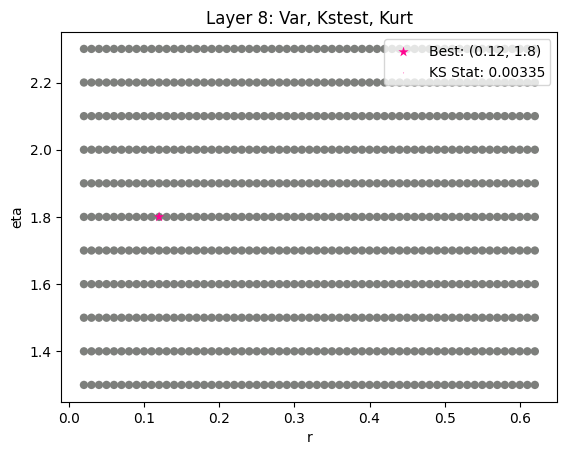

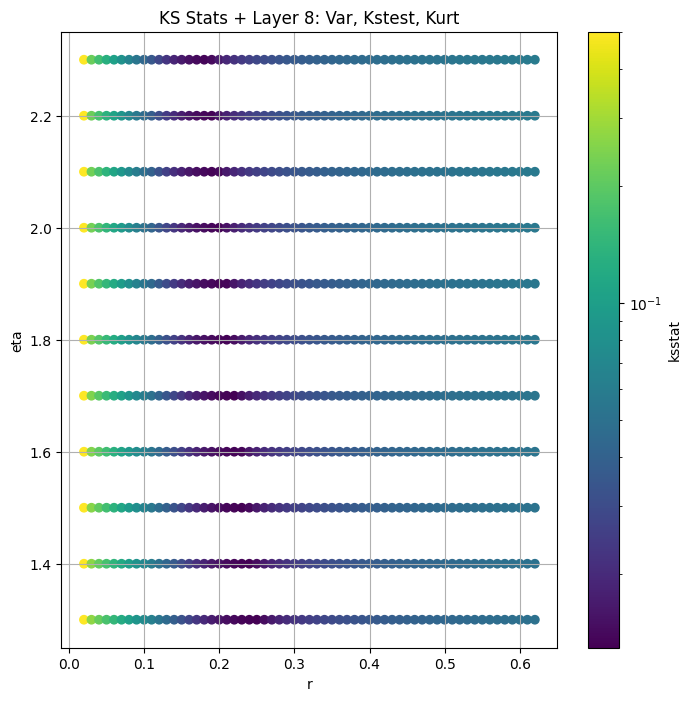

####
Layer  9


100%|██████████| 7460/7460 [00:26<00:00, 284.71it/s]


Finding Minimum after computing 7460 CDFs
9 0 0.024747447998198113 11.252635


100%|██████████| 7460/7460 [00:25<00:00, 289.13it/s]


Finding Minimum after computing 7460 CDFs
9 10 0.013494259218017335 5.6701565


100%|██████████| 7460/7460 [00:25<00:00, 293.26it/s]


Finding Minimum after computing 7460 CDFs
9 50 0.005950000000000011 3.8481076


100%|██████████| 7460/7460 [00:26<00:00, 283.47it/s]


Finding Minimum after computing 7460 CDFs
9 100 0.005949999999982691 3.2806263


100%|██████████| 7460/7460 [00:25<00:00, 292.38it/s]


Finding Minimum after computing 7460 CDFs
9 200 0.005949999999984024 2.8249547


100%|██████████| 7460/7460 [00:24<00:00, 301.43it/s]


Finding Minimum after computing 7460 CDFs
9 300 0.005949999999986244 2.5736582


100%|██████████| 7460/7460 [00:24<00:00, 301.87it/s]


Finding Minimum after computing 7460 CDFs
9 400 0.005949999999989797 2.3953981


100%|██████████| 7460/7460 [00:24<00:00, 299.65it/s]


Finding Minimum after computing 7460 CDFs
9 600 0.008368517509661139 2.1416545


100%|██████████| 7460/7460 [00:24<00:00, 302.23it/s]


Finding Minimum after computing 7460 CDFs
9 800 0.01067415200869393 1.9595398
Number of samples: 100000, Without approximation : 147456000.0


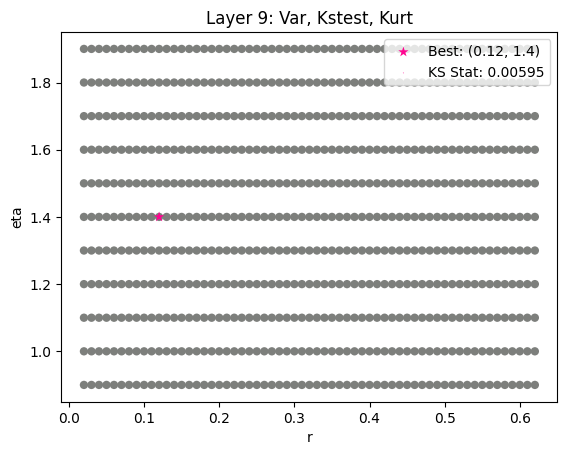

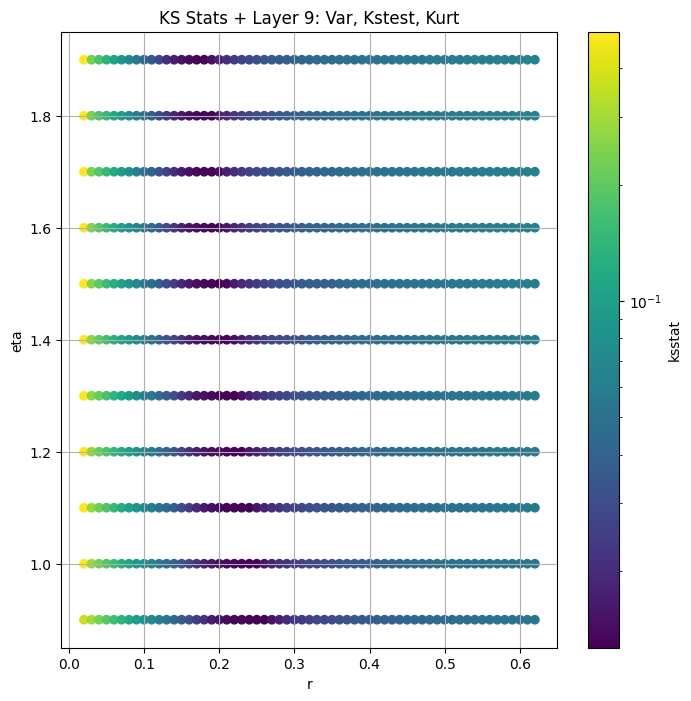

####
Layer  10


100%|██████████| 7460/7460 [00:24<00:00, 302.71it/s]


Finding Minimum after computing 7460 CDFs
10 0 0.02924344561515088 1.8759142


100%|██████████| 7460/7460 [00:25<00:00, 297.60it/s]


Finding Minimum after computing 7460 CDFs
10 10 0.026099999999987744 0.7875074


100%|██████████| 7460/7460 [00:24<00:00, 300.59it/s]


Finding Minimum after computing 7460 CDFs
10 50 0.02609999999998447 0.5432802


100%|██████████| 7460/7460 [00:24<00:00, 300.97it/s]


Finding Minimum after computing 7460 CDFs
10 100 0.026099999999981527 0.4631687


100%|██████████| 7460/7460 [00:24<00:00, 301.34it/s]


Finding Minimum after computing 7460 CDFs
10 200 0.02609999999998175 0.39541236


100%|██████████| 7460/7460 [00:24<00:00, 302.86it/s]


Finding Minimum after computing 7460 CDFs
10 300 0.02609999999998197 0.35778508


100%|██████████| 7460/7460 [00:24<00:00, 300.15it/s]


Finding Minimum after computing 7460 CDFs
10 400 0.026099999999983303 0.33112258


100%|██████████| 7460/7460 [00:24<00:00, 302.13it/s]


Finding Minimum after computing 7460 CDFs
10 600 0.026099999999985024 0.2932031


100%|██████████| 7460/7460 [00:24<00:00, 300.80it/s]


Finding Minimum after computing 7460 CDFs
10 800 0.0260999999999858 0.26609254
Number of samples: 100000, Without approximation : 589824000.0


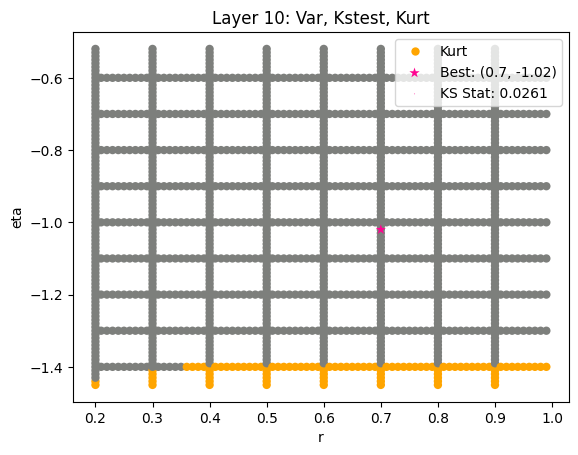

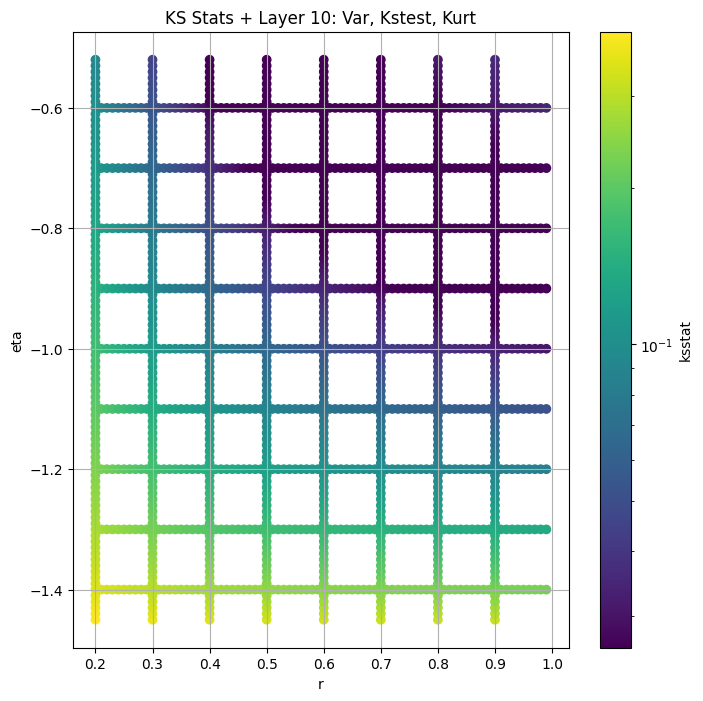

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,best_exclude_cutoff,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,,,
2,188570.730000,99638.340000,330262.220000,536.03296,113.304540,760.94360,9000.0,0.014756,0.18,0.70,1.645826e-02,50.0,0.014297
3,42568.312000,23773.760000,71607.330000,488.99530,135.974520,891.27313,36000.0,0.012923,0.06,4.10,3.767124e-30,200.0,0.007153
4,10773.336000,5322.670000,20877.791000,785.24280,131.392270,1768.95340,144000.0,0.007910,0.08,2.10,1.089326e-18,400.0,0.003578
5,1800.434900,923.853000,3624.655000,858.03740,109.913740,2074.88330,576000.0,0.005897,0.07,2.80,2.990083e-24,300.0,0.001789
6,390.887500,183.288650,971.469850,1521.53970,104.035530,3444.52950,2304000.0,0.004707,0.12,1.60,5.280963e-11,300.0,0.000895
7,98.479220,41.024357,351.604030,3306.70500,84.348870,5672.12000,9216000.0,0.003812,0.15,1.40,2.759916e-08,200.0,0.000447
8,33.173733,15.926921,100.374084,2264.61400,78.321760,4638.63770,36864000.0,0.003350,0.12,1.80,4.352079e-12,100.0,0.000224
9,11.252635,4.427865,43.877705,5137.09860,82.329865,6105.37160,147456000.0,0.005950,0.12,1.40,3.099728e-12,100.0,0.000112
10,1.875914,0.615992,10.184826,9775.98100,78.684250,7496.85840,589824000.0,0.026100,0.70,-1.02,5.807074e-01,100.0,0.000056


In [52]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for exclude_cutoff in EXCLUDE_CUTOFFS:
            if exclude_cutoff != 0:
                augmented_obs_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
            else:
                augmented_obs_var = np.var(group_data_map[group])
            group_cdf_df['scale'] = np.clip(augmented_obs_var / group_cdf_df['variance'], 0, SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdf_df['scale'])
            group_cdf_df[f'ksstat_{exclude_cutoff}'] = ksstats
            print(group, exclude_cutoff, min_stat, augmented_obs_var)
            if min_stat < master_df.loc[group, 'kstest_stat_initial']:
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdf_df.loc[(group_cdf_df["r"] ==  initial_param[0]) & (group_cdf_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
        
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df['variance'] = group_cdf_df['variance'] * group_cdf_df['scale']
        group_cdf_df['kurtosis'] = group_cdf_df['kurtosis'] * group_cdf_df['scale']

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df

        temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
        rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']] + [temp_df[f'ksstat_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS]

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

In [74]:
import optuna

sample = group_data_map[2]

def scale_min_stat(trial):
    scale_factor = trial.suggest_float("scale_factor", 1e-2, 100)
    group_cdf_df['scale'] = np.clip((np.var(sample) / scale_factor) / group_cdf_df['variance'], 0, SCALE_CAP)
    ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=False, scales=group_cdf_df['scale'])
    print(f"Scale factor: {scale_factor}, Min stat: {min_stat}")
    return min_stat

# Using optuna to find the optimal scale factor
study = optuna.create_study(direction="minimize")
study.optimize(scale_min_stat, n_trials=100)

print(f"Optimal scale factor: {study.best_params['scale_factor']}, Minimum statistic: {study.best_value}")


[I 2025-03-08 16:35:33,746] A new study created in memory with name: no-name-4410f574-ebd8-4d11-b138-aaf0a16fba79
[I 2025-03-08 16:35:34,961] Trial 0 finished with value: 0.20486597161795628 and parameters: {'scale_factor': 95.08240219400214}. Best is trial 0 with value: 0.20486597161795628.


Scale factor: 95.08240219400214, Min stat: 0.20486597161795628


[I 2025-03-08 16:35:36,243] Trial 1 finished with value: 0.09698278565537344 and parameters: {'scale_factor': 23.523173077332345}. Best is trial 1 with value: 0.09698278565537344.


Scale factor: 23.523173077332345, Min stat: 0.09698278565537344


[I 2025-03-08 16:35:37,456] Trial 2 finished with value: 0.1592764108754332 and parameters: {'scale_factor': 52.00718601356781}. Best is trial 1 with value: 0.09698278565537344.


Scale factor: 52.00718601356781, Min stat: 0.1592764108754332


[I 2025-03-08 16:35:38,498] Trial 3 finished with value: 0.2046882241753355 and parameters: {'scale_factor': 94.8538127059794}. Best is trial 1 with value: 0.09698278565537344.


Scale factor: 94.8538127059794, Min stat: 0.2046882241753355


[I 2025-03-08 16:35:39,585] Trial 4 finished with value: 0.2038676964784899 and parameters: {'scale_factor': 93.81107627831663}. Best is trial 1 with value: 0.09698278565537344.


Scale factor: 93.81107627831663, Min stat: 0.2038676964784899


[I 2025-03-08 16:35:40,649] Trial 5 finished with value: 0.16398037921646513 and parameters: {'scale_factor': 55.27542515791874}. Best is trial 1 with value: 0.09698278565537344.


Scale factor: 55.27542515791874, Min stat: 0.16398037921646513


[I 2025-03-08 16:35:41,811] Trial 6 finished with value: 0.14472608142867505 and parameters: {'scale_factor': 42.61959058268425}. Best is trial 1 with value: 0.09698278565537344.


Scale factor: 42.61959058268425, Min stat: 0.14472608142867505


[I 2025-03-08 16:35:42,905] Trial 7 finished with value: 0.1653354983002413 and parameters: {'scale_factor': 56.28382101917432}. Best is trial 1 with value: 0.09698278565537344.


Scale factor: 56.28382101917432, Min stat: 0.1653354983002413


[I 2025-03-08 16:35:43,952] Trial 8 finished with value: 0.20476976347712228 and parameters: {'scale_factor': 94.95855701509505}. Best is trial 1 with value: 0.09698278565537344.


Scale factor: 94.95855701509505, Min stat: 0.20476976347712228


[I 2025-03-08 16:35:45,001] Trial 9 finished with value: 0.16713741769063506 and parameters: {'scale_factor': 57.67608088761265}. Best is trial 1 with value: 0.09698278565537344.


Scale factor: 57.67608088761265, Min stat: 0.16713741769063506


[I 2025-03-08 16:35:46,063] Trial 10 finished with value: 0.02098472509565935 and parameters: {'scale_factor': 1.3966447600961018}. Best is trial 10 with value: 0.02098472509565935.


Scale factor: 1.3966447600961018, Min stat: 0.02098472509565935


[I 2025-03-08 16:35:47,169] Trial 11 finished with value: 0.013705988441538586 and parameters: {'scale_factor': 3.670430241741606}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 3.670430241741606, Min stat: 0.013705988441538586


[I 2025-03-08 16:35:48,207] Trial 12 finished with value: 0.025069297881073926 and parameters: {'scale_factor': 0.9191287734080797}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 0.9191287734080797, Min stat: 0.025069297881073926


[I 2025-03-08 16:35:49,234] Trial 13 finished with value: 0.04617071873619227 and parameters: {'scale_factor': 0.13918501582270237}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 0.13918501582270237, Min stat: 0.04617071873619227


[I 2025-03-08 16:35:50,272] Trial 14 finished with value: 0.08034015262109362 and parameters: {'scale_factor': 18.279109553319714}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 18.279109553319714, Min stat: 0.08034015262109362


[I 2025-03-08 16:35:51,366] Trial 15 finished with value: 0.08185254027298372 and parameters: {'scale_factor': 18.740457783877268}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 18.740457783877268, Min stat: 0.08185254027298372


[I 2025-03-08 16:35:52,410] Trial 16 finished with value: 0.12261155292226422 and parameters: {'scale_factor': 32.70930869473562}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 32.70930869473562, Min stat: 0.12261155292226422


[I 2025-03-08 16:35:53,452] Trial 17 finished with value: 0.18599559403250387 and parameters: {'scale_factor': 73.87537709827058}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 73.87537709827058, Min stat: 0.18599559403250387


[I 2025-03-08 16:35:54,485] Trial 18 finished with value: 0.017148455804958496 and parameters: {'scale_factor': 4.962788316818706}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 4.962788316818706, Min stat: 0.017148455804958496


[I 2025-03-08 16:35:55,521] Trial 19 finished with value: 0.06291981310942785 and parameters: {'scale_factor': 13.232345471143532}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 13.232345471143532, Min stat: 0.06291981310942785


[I 2025-03-08 16:35:56,560] Trial 20 finished with value: 0.11738896516784203 and parameters: {'scale_factor': 30.872769645295488}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 30.872769645295488, Min stat: 0.11738896516784203


[I 2025-03-08 16:35:57,602] Trial 21 finished with value: 0.03546803883540517 and parameters: {'scale_factor': 7.875003194740907}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 7.875003194740907, Min stat: 0.03546803883540517


[I 2025-03-08 16:35:58,643] Trial 22 finished with value: 0.03399656589258848 and parameters: {'scale_factor': 7.607925928029621}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 7.607925928029621, Min stat: 0.03399656589258848


[I 2025-03-08 16:35:59,730] Trial 23 finished with value: 0.10959947615224719 and parameters: {'scale_factor': 28.039299163092426}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 28.039299163092426, Min stat: 0.10959947615224719


[I 2025-03-08 16:36:00,774] Trial 24 finished with value: 0.03757930690125848 and parameters: {'scale_factor': 8.259391750654773}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 8.259391750654773, Min stat: 0.03757930690125848


[I 2025-03-08 16:36:01,883] Trial 25 finished with value: 0.14541671957230706 and parameters: {'scale_factor': 43.0033611164193}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 43.0033611164193, Min stat: 0.14541671957230706


[I 2025-03-08 16:36:02,921] Trial 26 finished with value: 0.04617071873619227 and parameters: {'scale_factor': 0.14246004762603204}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 0.14246004762603204, Min stat: 0.04617071873619227


[I 2025-03-08 16:36:03,980] Trial 27 finished with value: 0.07084676993962713 and parameters: {'scale_factor': 15.399321030755589}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 15.399321030755589, Min stat: 0.07084676993962713


[I 2025-03-08 16:36:05,033] Trial 28 finished with value: 0.18520475205455778 and parameters: {'scale_factor': 73.11392608545172}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 73.11392608545172, Min stat: 0.18520475205455778


[I 2025-03-08 16:36:06,087] Trial 29 finished with value: 0.05166741909541972 and parameters: {'scale_factor': 10.822998383039012}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 10.822998383039012, Min stat: 0.05166741909541972


[I 2025-03-08 16:36:07,169] Trial 30 finished with value: 0.13347189095917167 and parameters: {'scale_factor': 37.09594565919515}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 37.09594565919515, Min stat: 0.13347189095917167


[I 2025-03-08 16:36:08,205] Trial 31 finished with value: 0.023909480139919448 and parameters: {'scale_factor': 1.0419146927038474}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 1.0419146927038474, Min stat: 0.023909480139919448


[I 2025-03-08 16:36:09,248] Trial 32 finished with value: 0.1029552420361236 and parameters: {'scale_factor': 25.683778238634794}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 25.683778238634794, Min stat: 0.1029552420361236


[I 2025-03-08 16:36:10,294] Trial 33 finished with value: 0.0923395015281393 and parameters: {'scale_factor': 21.935664539591077}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 21.935664539591077, Min stat: 0.0923395015281393


[I 2025-03-08 16:36:11,332] Trial 34 finished with value: 0.016606012165994333 and parameters: {'scale_factor': 4.820596553805683}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 4.820596553805683, Min stat: 0.016606012165994333


[I 2025-03-08 16:36:12,369] Trial 35 finished with value: 0.027237938514301008 and parameters: {'scale_factor': 6.440174919132991}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 6.440174919132991, Min stat: 0.027237938514301008


[I 2025-03-08 16:36:13,412] Trial 36 finished with value: 0.06747780990280694 and parameters: {'scale_factor': 14.390021465565411}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 14.390021465565411, Min stat: 0.06747780990280694


[I 2025-03-08 16:36:14,455] Trial 37 finished with value: 0.08905082196412872 and parameters: {'scale_factor': 20.89512025961472}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 20.89512025961472, Min stat: 0.08905082196412872


[I 2025-03-08 16:36:15,539] Trial 38 finished with value: 0.027261895989356133 and parameters: {'scale_factor': 6.4446820121910395}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 6.4446820121910395, Min stat: 0.027261895989356133


[I 2025-03-08 16:36:16,577] Trial 39 finished with value: 0.06758455975208211 and parameters: {'scale_factor': 14.421104874019015}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 14.421104874019015, Min stat: 0.06758455975208211


[I 2025-03-08 16:36:17,619] Trial 40 finished with value: 0.19729335890955269 and parameters: {'scale_factor': 86.12926287186738}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 86.12926287186738, Min stat: 0.19729335890955269


[I 2025-03-08 16:36:18,658] Trial 41 finished with value: 0.014835590116040576 and parameters: {'scale_factor': 4.17845658771071}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 4.17845658771071, Min stat: 0.014835590116040576


[I 2025-03-08 16:36:19,699] Trial 42 finished with value: 0.015607269390819578 and parameters: {'scale_factor': 4.566325748760422}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 4.566325748760422, Min stat: 0.015607269390819578


[I 2025-03-08 16:36:20,825] Trial 43 finished with value: 0.023012390821676276 and parameters: {'scale_factor': 5.812846530100927}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 5.812846530100927, Min stat: 0.023012390821676276


[I 2025-03-08 16:36:21,876] Trial 44 finished with value: 0.04962693164825338 and parameters: {'scale_factor': 10.437682205032232}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 10.437682205032232, Min stat: 0.04962693164825338


[I 2025-03-08 16:36:22,954] Trial 45 finished with value: 0.015767697109667522 and parameters: {'scale_factor': 4.6197917314983075}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 4.6197917314983075, Min stat: 0.015767697109667522


[I 2025-03-08 16:36:24,001] Trial 46 finished with value: 0.0790975823245309 and parameters: {'scale_factor': 17.906555444418224}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 17.906555444418224, Min stat: 0.0790975823245309


[I 2025-03-08 16:36:25,043] Trial 47 finished with value: 0.09798313821662197 and parameters: {'scale_factor': 23.88191314505848}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 23.88191314505848, Min stat: 0.09798313821662197


[I 2025-03-08 16:36:26,079] Trial 48 finished with value: 0.013872387513926498 and parameters: {'scale_factor': 3.5525145651750942}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 3.5525145651750942, Min stat: 0.013872387513926498


[I 2025-03-08 16:36:27,125] Trial 49 finished with value: 0.05448717673329884 and parameters: {'scale_factor': 11.421046593852445}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 11.421046593852445, Min stat: 0.05448717673329884


[I 2025-03-08 16:36:28,180] Trial 50 finished with value: 0.014048152075858633 and parameters: {'scale_factor': 3.3685245290733845}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 3.3685245290733845, Min stat: 0.014048152075858633


[I 2025-03-08 16:36:29,218] Trial 51 finished with value: 0.015355541004851592 and parameters: {'scale_factor': 2.679557465742326}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 2.679557465742326, Min stat: 0.015355541004851592


[I 2025-03-08 16:36:30,295] Trial 52 finished with value: 0.01456360964143677 and parameters: {'scale_factor': 3.3009700323595492}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 3.3009700323595492, Min stat: 0.01456360964143677


[I 2025-03-08 16:36:31,399] Trial 53 finished with value: 0.17533093256751908 and parameters: {'scale_factor': 64.36080917814913}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 64.36080917814913, Min stat: 0.17533093256751908


[I 2025-03-08 16:36:32,454] Trial 54 finished with value: 0.04959901193358318 and parameters: {'scale_factor': 10.432619536115194}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 10.432619536115194, Min stat: 0.04959901193358318


[I 2025-03-08 16:36:33,508] Trial 55 finished with value: 0.03564895014100722 and parameters: {'scale_factor': 0.4212891242677217}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 0.4212891242677217, Min stat: 0.03564895014100722


[I 2025-03-08 16:36:34,551] Trial 56 finished with value: 0.07415009916764104 and parameters: {'scale_factor': 16.411986206425645}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 16.411986206425645, Min stat: 0.07415009916764104


[I 2025-03-08 16:36:35,592] Trial 57 finished with value: 0.014677180333375978 and parameters: {'scale_factor': 3.21460514239283}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 3.21460514239283, Min stat: 0.014677180333375978


[I 2025-03-08 16:36:36,634] Trial 58 finished with value: 0.15373654471631204 and parameters: {'scale_factor': 48.152037693796906}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 48.152037693796906, Min stat: 0.15373654471631204


[I 2025-03-08 16:36:37,677] Trial 59 finished with value: 0.20807141049306865 and parameters: {'scale_factor': 99.17619191927118}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 99.17619191927118, Min stat: 0.20807141049306865


[I 2025-03-08 16:36:38,767] Trial 60 finished with value: 0.045808002756362244 and parameters: {'scale_factor': 9.7295236836146}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 9.7295236836146, Min stat: 0.045808002756362244


[I 2025-03-08 16:36:39,825] Trial 61 finished with value: 0.013799484269713613 and parameters: {'scale_factor': 3.6604697047295707}. Best is trial 11 with value: 0.013705988441538586.


Scale factor: 3.6604697047295707, Min stat: 0.013799484269713613


[I 2025-03-08 16:36:40,881] Trial 62 finished with value: 0.013527577204250019 and parameters: {'scale_factor': 3.7458498413933796}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 3.7458498413933796, Min stat: 0.013527577204250019


[I 2025-03-08 16:36:41,922] Trial 63 finished with value: 0.06281501889160257 and parameters: {'scale_factor': 13.208789835257646}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 13.208789835257646, Min stat: 0.06281501889160257


[I 2025-03-08 16:36:42,965] Trial 64 finished with value: 0.040726277262245765 and parameters: {'scale_factor': 8.810987384391273}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 8.810987384391273, Min stat: 0.040726277262245765


[I 2025-03-08 16:36:44,014] Trial 65 finished with value: 0.016065087311956328 and parameters: {'scale_factor': 2.5456733792592527}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 2.5456733792592527, Min stat: 0.016065087311956328


[I 2025-03-08 16:36:45,126] Trial 66 finished with value: 0.08252327173157892 and parameters: {'scale_factor': 18.947259575704262}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 18.947259575704262, Min stat: 0.08252327173157892


[I 2025-03-08 16:36:46,199] Trial 67 finished with value: 0.04135696714646875 and parameters: {'scale_factor': 0.2960664819246066}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 0.2960664819246066, Min stat: 0.04135696714646875


[I 2025-03-08 16:36:47,238] Trial 68 finished with value: 0.05975829071302996 and parameters: {'scale_factor': 12.545439687739535}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 12.545439687739535, Min stat: 0.05975829071302996


[I 2025-03-08 16:36:48,281] Trial 69 finished with value: 0.028348896449041483 and parameters: {'scale_factor': 6.614719571525022}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 6.614719571525022, Min stat: 0.028348896449041483


[I 2025-03-08 16:36:49,321] Trial 70 finished with value: 0.03817795094153453 and parameters: {'scale_factor': 8.366757638500465}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 8.366757638500465, Min stat: 0.03817795094153453


[I 2025-03-08 16:36:50,361] Trial 71 finished with value: 0.014340944091969954 and parameters: {'scale_factor': 3.2352232763910727}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 3.2352232763910727, Min stat: 0.014340944091969954


[I 2025-03-08 16:36:51,412] Trial 72 finished with value: 0.013982813685446072 and parameters: {'scale_factor': 3.462177194621428}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 3.462177194621428, Min stat: 0.013982813685446072


[I 2025-03-08 16:36:52,449] Trial 73 finished with value: 0.015926611693548365 and parameters: {'scale_factor': 2.623404744149255}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 2.623404744149255, Min stat: 0.015926611693548365


[I 2025-03-08 16:36:53,519] Trial 74 finished with value: 0.04617071873619227 and parameters: {'scale_factor': 0.019621037490449744}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 0.019621037490449744, Min stat: 0.04617071873619227


[I 2025-03-08 16:36:54,571] Trial 75 finished with value: 0.03428145842779614 and parameters: {'scale_factor': 7.660084133320881}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 7.660084133320881, Min stat: 0.03428145842779614


[I 2025-03-08 16:36:55,613] Trial 76 finished with value: 0.0492820138125879 and parameters: {'scale_factor': 10.374543948145938}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 10.374543948145938, Min stat: 0.0492820138125879


[I 2025-03-08 16:36:56,665] Trial 77 finished with value: 0.07218860165948515 and parameters: {'scale_factor': 15.812753568688446}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 15.812753568688446, Min stat: 0.07218860165948515


[I 2025-03-08 16:36:57,711] Trial 78 finished with value: 0.13040252963785126 and parameters: {'scale_factor': 35.78107803166041}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 35.78107803166041, Min stat: 0.13040252963785126


[I 2025-03-08 16:36:58,752] Trial 79 finished with value: 0.058915213588913606 and parameters: {'scale_factor': 12.368198557655255}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 12.368198557655255, Min stat: 0.058915213588913606


[I 2025-03-08 16:36:59,882] Trial 80 finished with value: 0.015313335796582006 and parameters: {'scale_factor': 4.497219368366093}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 4.497219368366093, Min stat: 0.015313335796582006


[I 2025-03-08 16:37:00,935] Trial 81 finished with value: 0.014373783749358826 and parameters: {'scale_factor': 3.1911586169927704}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 3.1911586169927704, Min stat: 0.014373783749358826


[I 2025-03-08 16:37:02,061] Trial 82 finished with value: 0.028575905497478238 and parameters: {'scale_factor': 6.650965213111668}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 6.650965213111668, Min stat: 0.028575905497478238


[I 2025-03-08 16:37:03,135] Trial 83 finished with value: 0.014861372978710957 and parameters: {'scale_factor': 3.150814849091743}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 3.150814849091743, Min stat: 0.014861372978710957


[I 2025-03-08 16:37:04,185] Trial 84 finished with value: 0.035503911185153725 and parameters: {'scale_factor': 7.882519997977111}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 7.882519997977111, Min stat: 0.035503911185153725


[I 2025-03-08 16:37:05,245] Trial 85 finished with value: 0.01746766117562204 and parameters: {'scale_factor': 2.1138762817875154}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 2.1138762817875154, Min stat: 0.01746766117562204


[I 2025-03-08 16:37:06,295] Trial 86 finished with value: 0.01735661618683315 and parameters: {'scale_factor': 5.008290233344466}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 5.008290233344466, Min stat: 0.01735661618683315


[I 2025-03-08 16:37:07,380] Trial 87 finished with value: 0.1950704169629509 and parameters: {'scale_factor': 83.72372333215347}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 83.72372333215347, Min stat: 0.1950704169629509


[I 2025-03-08 16:37:08,458] Trial 88 finished with value: 0.1699302963408037 and parameters: {'scale_factor': 59.95999707243759}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 59.95999707243759, Min stat: 0.1699302963408037


[I 2025-03-08 16:37:09,501] Trial 89 finished with value: 0.08613749153697825 and parameters: {'scale_factor': 20.047116724703447}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 20.047116724703447, Min stat: 0.08613749153697825


[I 2025-03-08 16:37:10,614] Trial 90 finished with value: 0.07508103175112846 and parameters: {'scale_factor': 16.69709785598318}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 16.69709785598318, Min stat: 0.07508103175112846


[I 2025-03-08 16:37:11,738] Trial 91 finished with value: 0.013985305082035437 and parameters: {'scale_factor': 3.9262104365582284}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 3.9262104365582284, Min stat: 0.013985305082035437


[I 2025-03-08 16:37:12,778] Trial 92 finished with value: 0.01874216436635745 and parameters: {'scale_factor': 5.206218461403677}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 5.206218461403677, Min stat: 0.01874216436635745


[I 2025-03-08 16:37:13,866] Trial 93 finished with value: 0.04388664675185946 and parameters: {'scale_factor': 9.372657240453233}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 9.372657240453233, Min stat: 0.04388664675185946


[I 2025-03-08 16:37:14,906] Trial 94 finished with value: 0.01913199772284699 and parameters: {'scale_factor': 1.820195708223888}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 1.820195708223888, Min stat: 0.01913199772284699


[I 2025-03-08 16:37:15,947] Trial 95 finished with value: 0.064933258536228 and parameters: {'scale_factor': 13.70615062265582}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 13.70615062265582, Min stat: 0.064933258536228


[I 2025-03-08 16:37:16,976] Trial 96 finished with value: 0.04617071873619227 and parameters: {'scale_factor': 0.04798176631296602}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 0.04798176631296602, Min stat: 0.04617071873619227


[I 2025-03-08 16:37:18,020] Trial 97 finished with value: 0.02900627811824341 and parameters: {'scale_factor': 6.717910587579804}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 6.717910587579804, Min stat: 0.02900627811824341


[I 2025-03-08 16:37:19,059] Trial 98 finished with value: 0.054905947060649773 and parameters: {'scale_factor': 11.510384068227477}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 11.510384068227477, Min stat: 0.054905947060649773


[I 2025-03-08 16:37:20,098] Trial 99 finished with value: 0.013569512507999981 and parameters: {'scale_factor': 3.713014979813104}. Best is trial 62 with value: 0.013527577204250019.


Scale factor: 3.713014979813104, Min stat: 0.013569512507999981
Optimal scale factor: 3.7458498413933796, Minimum statistic: 0.013527577204250019


### Search over $\eta=0$

In [ ]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True, scales=group_cdf_df['scale'])
            best_scale_eta0 = group_cdf_df.loc[(group_cdf_df["r"] ==  best_param_eta0[0]) & (group_cdf_df["eta"] ==  best_param_eta0[1])]["scale"].iloc[0]
            master_df.loc[group, 'best_r_eta0'] = best_param_eta0[0]
            master_df.loc[group, 'best_scale_eta0'] = best_scale_eta0
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r_eta0'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_scale_eta0'] = master_df.loc[group, 'initial_scale']
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

## Optimization

In [ ]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

In [ ]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / temp_df['variance'], 0, 1e5)
                temp_df['variance'] = temp_df['variance'] * temp_df['scale']
                temp_df['kurtosis'] = temp_df['kurtosis'] * temp_df['scale']
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True, scales=temp_df['scale'])
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                best_scale = temp_df.loc[(temp_df["r"] ==  best_param[0])&(temp_df["eta"] ==  best_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'best_scale'] = best_scale
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=kstest_stat)
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

In [ ]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [ ]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [27]:
import optuna
print(generate_func(sample=sample, distro='prior_with_scale', n_samples=1000)([0.05, 4.8, -38]))
sample = group_data_map[2]

def objective(trial):
    r = trial.suggest_float("r", 0.05, 0.2)
    eta = trial.suggest_float("eta", 4, 6)
    scale = trial.suggest_float("scale", 1e-38, 2e-38)
    
    func = generate_func(sample=sample, distro='prior_with_scale', n_samples=1000)
    ks_stat = func([r, eta, scale])
    
    return ks_stat

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_ks_stat = study.best_value

print(f"Best r: {best_params['r']}, Best eta: {best_params['eta']}, Best scale: {best_params['scale']}, Best KS stat: {best_ks_stat}")

0.05 4.8 -38


[I 2025-03-08 16:56:17,654] A new study created in memory with name: no-name-b7b52939-3fca-4ebf-ac37-b9246ff5082a


0.042924551417031775
0.15572719849890596 5.38187985988219 1.9658309614080253e-38


[I 2025-03-08 16:56:18,462] Trial 0 finished with value: 0.4942277402208222 and parameters: {'r': 0.15572719849890596, 'eta': 5.38187985988219, 'scale': 1.9658309614080253e-38}. Best is trial 0 with value: 0.4942277402208222.


0.15759010221922864 4.0026342149171334 1.5715272483320232e-38


[I 2025-03-08 16:56:19,311] Trial 1 finished with value: 0.48895068764148264 and parameters: {'r': 0.15759010221922864, 'eta': 4.0026342149171334, 'scale': 1.5715272483320232e-38}. Best is trial 1 with value: 0.48895068764148264.


0.184410307709566 5.081254314506566 1.8041629308159625e-38


[I 2025-03-08 16:56:20,040] Trial 2 finished with value: 0.4669930285492011 and parameters: {'r': 0.184410307709566, 'eta': 5.081254314506566, 'scale': 1.8041629308159625e-38}. Best is trial 2 with value: 0.4669930285492011.


0.12195141843875279 4.183671015284448 1.5035120268909382e-38


[I 2025-03-08 16:56:20,784] Trial 3 finished with value: 0.4993688666482066 and parameters: {'r': 0.12195141843875279, 'eta': 4.183671015284448, 'scale': 1.5035120268909382e-38}. Best is trial 2 with value: 0.4669930285492011.


0.08130782975617476 5.885383901300047 1.6832266293471857e-38


[I 2025-03-08 16:56:21,461] Trial 4 finished with value: 0.4999999999395379 and parameters: {'r': 0.08130782975617476, 'eta': 5.885383901300047, 'scale': 1.6832266293471857e-38}. Best is trial 2 with value: 0.4669930285492011.


0.0609254205658704 5.800932568815723 1.2914901128435555e-38


[I 2025-03-08 16:56:22,137] Trial 5 finished with value: 0.5 and parameters: {'r': 0.0609254205658704, 'eta': 5.800932568815723, 'scale': 1.2914901128435555e-38}. Best is trial 2 with value: 0.4669930285492011.


0.11251924038755629 4.930036927937087 1.7236442015839167e-38


[I 2025-03-08 16:56:22,824] Trial 6 finished with value: 0.49987367007597505 and parameters: {'r': 0.11251924038755629, 'eta': 4.930036927937087, 'scale': 1.7236442015839167e-38}. Best is trial 2 with value: 0.4669930285492011.


0.1227997488444053 4.49763490327177 1.2715242595096728e-38


[I 2025-03-08 16:56:23,560] Trial 7 finished with value: 0.49941630404422654 and parameters: {'r': 0.1227997488444053, 'eta': 4.49763490327177, 'scale': 1.2715242595096728e-38}. Best is trial 2 with value: 0.4669930285492011.


0.07987518004740396 5.9505238565516265 1.9543656722826413e-38


[I 2025-03-08 16:56:24,250] Trial 8 finished with value: 0.4999999999985484 and parameters: {'r': 0.07987518004740396, 'eta': 5.9505238565516265, 'scale': 1.9543656722826413e-38}. Best is trial 2 with value: 0.4669930285492011.


0.0833493323387893 4.000458964023475 1.2576043568927095e-38


[I 2025-03-08 16:56:25,050] Trial 9 finished with value: 0.4999997799687106 and parameters: {'r': 0.0833493323387893, 'eta': 4.000458964023475, 'scale': 1.2576043568927095e-38}. Best is trial 2 with value: 0.4669930285492011.


0.19696038913553154 5.066888314845864 1.8175394950438527e-38


[I 2025-03-08 16:56:25,794] Trial 10 finished with value: 0.4419100915992289 and parameters: {'r': 0.19696038913553154, 'eta': 5.066888314845864, 'scale': 1.8175394950438527e-38}. Best is trial 10 with value: 0.4419100915992289.


0.19328276400280717 5.024579590165028 1.8154204400236663e-38


[I 2025-03-08 16:56:26,517] Trial 11 finished with value: 0.44942603540164117 and parameters: {'r': 0.19328276400280717, 'eta': 5.024579590165028, 'scale': 1.8154204400236663e-38}. Best is trial 10 with value: 0.4419100915992289.


0.18748293754482864 4.836627929106602 1.8307670690309762e-38


[I 2025-03-08 16:56:27,246] Trial 12 finished with value: 0.458630246946804 and parameters: {'r': 0.18748293754482864, 'eta': 4.836627929106602, 'scale': 1.8307670690309762e-38}. Best is trial 10 with value: 0.4419100915992289.


0.19925416306047392 5.291886874855072 1.6148466652125867e-38


[I 2025-03-08 16:56:28,044] Trial 13 finished with value: 0.44020075853076 and parameters: {'r': 0.19925416306047392, 'eta': 5.291886874855072, 'scale': 1.6148466652125867e-38}. Best is trial 13 with value: 0.44020075853076.


0.16491110192665312 5.449855064836637 1.0993930587959305e-38


[I 2025-03-08 16:56:28,890] Trial 14 finished with value: 0.4897418794772724 and parameters: {'r': 0.16491110192665312, 'eta': 5.449855064836637, 'scale': 1.0993930587959305e-38}. Best is trial 13 with value: 0.44020075853076.


0.17087513791180486 5.4835432402982365 1.6427507092406343e-38


[I 2025-03-08 16:56:29,689] Trial 15 finished with value: 0.48580824541140455 and parameters: {'r': 0.17087513791180486, 'eta': 5.4835432402982365, 'scale': 1.6427507092406343e-38}. Best is trial 13 with value: 0.44020075853076.


0.14643285453493796 4.6642476078827695 1.406461809091381e-38


[I 2025-03-08 16:56:30,569] Trial 16 finished with value: 0.4960256796725206 and parameters: {'r': 0.14643285453493796, 'eta': 4.6642476078827695, 'scale': 1.406461809091381e-38}. Best is trial 13 with value: 0.44020075853076.


0.14068951058317436 5.236939657465346 1.4663215699226294e-38


[I 2025-03-08 16:56:31,527] Trial 17 finished with value: 0.4979635562001312 and parameters: {'r': 0.14068951058317436, 'eta': 5.236939657465346, 'scale': 1.4663215699226294e-38}. Best is trial 13 with value: 0.44020075853076.


0.19842123111178867 5.608055621637698 1.5730444031353683e-38


[I 2025-03-08 16:56:32,372] Trial 18 finished with value: 0.4467906393150066 and parameters: {'r': 0.19842123111178867, 'eta': 5.608055621637698, 'scale': 1.5730444031353683e-38}. Best is trial 13 with value: 0.44020075853076.


0.17632064893758798 5.247898012768246 1.8859667369266983e-38


[I 2025-03-08 16:56:33,102] Trial 19 finished with value: 0.47930292138841596 and parameters: {'r': 0.17632064893758798, 'eta': 5.247898012768246, 'scale': 1.8859667369266983e-38}. Best is trial 13 with value: 0.44020075853076.


0.10293346107219666 4.728736560341255 1.0163530636801149e-38


[I 2025-03-08 16:56:33,819] Trial 20 finished with value: 0.4999815464742381 and parameters: {'r': 0.10293346107219666, 'eta': 4.728736560341255, 'scale': 1.0163530636801149e-38}. Best is trial 13 with value: 0.44020075853076.


0.19906071020708319 5.717178740541107 1.5947604536922546e-38


[I 2025-03-08 16:56:34,545] Trial 21 finished with value: 0.4469216603270618 and parameters: {'r': 0.19906071020708319, 'eta': 5.717178740541107, 'scale': 1.5947604536922546e-38}. Best is trial 13 with value: 0.44020075853076.


0.19825247056951575 5.63181892359319 1.7314185647990197e-38


[I 2025-03-08 16:56:35,281] Trial 22 finished with value: 0.4474907992627716 and parameters: {'r': 0.19825247056951575, 'eta': 5.63181892359319, 'scale': 1.7314185647990197e-38}. Best is trial 13 with value: 0.44020075853076.


0.18557917053355863 5.250055143496339 1.5086066555026507e-38


[I 2025-03-08 16:56:35,998] Trial 23 finished with value: 0.46686287348901945 and parameters: {'r': 0.18557917053355863, 'eta': 5.250055143496339, 'scale': 1.5086066555026507e-38}. Best is trial 13 with value: 0.44020075853076.


0.17926550620510934 5.602352350851627 1.3676912829463578e-38


[I 2025-03-08 16:56:36,728] Trial 24 finished with value: 0.4783175844793557 and parameters: {'r': 0.17926550620510934, 'eta': 5.602352350851627, 'scale': 1.3676912829463578e-38}. Best is trial 13 with value: 0.44020075853076.


0.13857412733922772 5.10345272742415 1.6078880682099953e-38


[I 2025-03-08 16:56:37,539] Trial 25 finished with value: 0.49819673957623106 and parameters: {'r': 0.13857412733922772, 'eta': 5.10345272742415, 'scale': 1.6078880682099953e-38}. Best is trial 13 with value: 0.44020075853076.


0.16636069637645168 5.515516115072804 1.714374998435757e-38


[I 2025-03-08 16:56:38,293] Trial 26 finished with value: 0.48911092246238674 and parameters: {'r': 0.16636069637645168, 'eta': 5.515516115072804, 'scale': 1.714374998435757e-38}. Best is trial 13 with value: 0.44020075853076.


0.1998286059118445 5.352366106438117 1.8836344197359063e-38


[I 2025-03-08 16:56:39,073] Trial 27 finished with value: 0.4398175264070733 and parameters: {'r': 0.1998286059118445, 'eta': 5.352366106438117, 'scale': 1.8836344197359063e-38}. Best is trial 27 with value: 0.4398175264070733.


0.17856576904998925 4.462886449889996 1.874784216411104e-38


[I 2025-03-08 16:56:39,853] Trial 28 finished with value: 0.46956144733338023 and parameters: {'r': 0.17856576904998925, 'eta': 4.462886449889996, 'scale': 1.874784216411104e-38}. Best is trial 27 with value: 0.4398175264070733.


0.1523515201451267 5.324946293732743 1.9458426570287405e-38


[I 2025-03-08 16:56:40,736] Trial 29 finished with value: 0.49528044673620725 and parameters: {'r': 0.1523515201451267, 'eta': 5.324946293732743, 'scale': 1.9458426570287405e-38}. Best is trial 27 with value: 0.4398175264070733.


0.1606046407705484 5.125227455274348 1.9829363048906903e-38


[I 2025-03-08 16:56:41,483] Trial 30 finished with value: 0.4912207536519491 and parameters: {'r': 0.1606046407705484, 'eta': 5.125227455274348, 'scale': 1.9829363048906903e-38}. Best is trial 27 with value: 0.4398175264070733.


0.19963099774339413 5.426743568930671 1.765147826138844e-38


[I 2025-03-08 16:56:42,216] Trial 31 finished with value: 0.4414749300689764 and parameters: {'r': 0.19963099774339413, 'eta': 5.426743568930671, 'scale': 1.765147826138844e-38}. Best is trial 27 with value: 0.4398175264070733.


0.18912477527532745 5.4129598025497065 1.7816264191635815e-38


[I 2025-03-08 16:56:42,934] Trial 32 finished with value: 0.4626916628673541 and parameters: {'r': 0.18912477527532745, 'eta': 5.4129598025497065, 'scale': 1.7816264191635815e-38}. Best is trial 27 with value: 0.4398175264070733.


0.19994321440582197 4.898032318526172 1.892012180381422e-38


[I 2025-03-08 16:56:43,728] Trial 33 finished with value: 0.43228965901660177 and parameters: {'r': 0.19994321440582197, 'eta': 4.898032318526172, 'scale': 1.892012180381422e-38}. Best is trial 33 with value: 0.43228965901660177.


0.17439286402463727 5.294606573105914 1.8830633690670982e-38


[I 2025-03-08 16:56:44,474] Trial 34 finished with value: 0.48166718607289316 and parameters: {'r': 0.17439286402463727, 'eta': 5.294606573105914, 'scale': 1.8830633690670982e-38}. Best is trial 33 with value: 0.43228965901660177.


0.1849793910233559 4.930515595568589 1.6664009661788142e-38


[I 2025-03-08 16:56:45,260] Trial 35 finished with value: 0.4644003470401219 and parameters: {'r': 0.1849793910233559, 'eta': 4.930515595568589, 'scale': 1.6664009661788142e-38}. Best is trial 33 with value: 0.43228965901660177.


0.18939187343628414 5.165928205300376 1.7473476426834891e-38


[I 2025-03-08 16:56:46,038] Trial 36 finished with value: 0.45927729487357094 and parameters: {'r': 0.18939187343628414, 'eta': 5.165928205300376, 'scale': 1.7473476426834891e-38}. Best is trial 33 with value: 0.43228965901660177.


0.18214402442813762 4.79336742532859 1.9197439163444075e-38


[I 2025-03-08 16:56:46,777] Trial 37 finished with value: 0.46754561228278124 and parameters: {'r': 0.18214402442813762, 'eta': 4.79336742532859, 'scale': 1.9197439163444075e-38}. Best is trial 33 with value: 0.43228965901660177.


0.16864170882571988 4.593407639864114 1.7646399819057198e-38


[I 2025-03-08 16:56:47,508] Trial 38 finished with value: 0.4831273499015475 and parameters: {'r': 0.16864170882571988, 'eta': 4.593407639864114, 'scale': 1.7646399819057198e-38}. Best is trial 33 with value: 0.43228965901660177.


0.15703415767789083 4.28295500984626 1.5296877440828003e-38


[I 2025-03-08 16:56:48,279] Trial 39 finished with value: 0.49035716136161034 and parameters: {'r': 0.15703415767789083, 'eta': 4.28295500984626, 'scale': 1.5296877440828003e-38}. Best is trial 33 with value: 0.43228965901660177.


0.19182518720442931 4.939633347621067 1.9894208883349676e-38


[I 2025-03-08 16:56:49,023] Trial 40 finished with value: 0.45122224851247406 and parameters: {'r': 0.19182518720442931, 'eta': 4.939633347621067, 'scale': 1.9894208883349676e-38}. Best is trial 33 with value: 0.43228965901660177.


0.1998025597876962 5.076229287891738 1.8548248720690313e-38


[I 2025-03-08 16:56:49,798] Trial 41 finished with value: 0.4354171336294238 and parameters: {'r': 0.1998025597876962, 'eta': 5.076229287891738, 'scale': 1.8548248720690313e-38}. Best is trial 33 with value: 0.43228965901660177.


0.19902664112162954 5.349244290857472 1.84877105468816e-38


[I 2025-03-08 16:56:50,584] Trial 42 finished with value: 0.4416612962056664 and parameters: {'r': 0.19902664112162954, 'eta': 5.349244290857472, 'scale': 1.84877105468816e-38}. Best is trial 33 with value: 0.43228965901660177.


0.191522973976812 5.010020332553826 1.6981263116381035e-38


[I 2025-03-08 16:56:51,335] Trial 43 finished with value: 0.4528162574259923 and parameters: {'r': 0.191522973976812, 'eta': 5.010020332553826, 'scale': 1.6981263116381035e-38}. Best is trial 33 with value: 0.43228965901660177.


0.179616410818709 5.165190176790562 1.908394708403378e-38


[I 2025-03-08 16:56:52,107] Trial 44 finished with value: 0.47460097644845867 and parameters: {'r': 0.179616410818709, 'eta': 5.165190176790562, 'scale': 1.908394708403378e-38}. Best is trial 33 with value: 0.43228965901660177.


0.19224619579027008 5.802827011929999 1.7866539522623638e-38


[I 2025-03-08 16:56:52,914] Trial 45 finished with value: 0.46142492461794793 and parameters: {'r': 0.19224619579027008, 'eta': 5.802827011929999, 'scale': 1.7866539522623638e-38}. Best is trial 33 with value: 0.43228965901660177.


0.06331995560607206 5.3680558761639325 1.8405174442651053e-38


[I 2025-03-08 16:56:53,682] Trial 46 finished with value: 0.5000000000000002 and parameters: {'r': 0.06331995560607206, 'eta': 5.3680558761639325, 'scale': 1.8405174442651053e-38}. Best is trial 33 with value: 0.43228965901660177.


0.19998824813937224 4.873125139502138 1.6382593818274493e-38


[I 2025-03-08 16:56:54,499] Trial 47 finished with value: 0.4317686161601576 and parameters: {'r': 0.19998824813937224, 'eta': 4.873125139502138, 'scale': 1.6382593818274493e-38}. Best is trial 47 with value: 0.4317686161601576.


0.1850034927111688 4.869193659785262 1.6407121540731323e-38


[I 2025-03-08 16:56:55,324] Trial 48 finished with value: 0.4636505997845689 and parameters: {'r': 0.1850034927111688, 'eta': 4.869193659785262, 'scale': 1.6407121540731323e-38}. Best is trial 47 with value: 0.4317686161601576.


0.09947132036433884 4.750810295260527 1.944257214423203e-38


[I 2025-03-08 16:56:56,228] Trial 49 finished with value: 0.49999235546967613 and parameters: {'r': 0.09947132036433884, 'eta': 4.750810295260527, 'scale': 1.944257214423203e-38}. Best is trial 47 with value: 0.4317686161601576.


0.12887725760571564 4.979059083556252 1.436330482674942e-38


[I 2025-03-08 16:56:57,021] Trial 50 finished with value: 0.4990189739981901 and parameters: {'r': 0.12887725760571564, 'eta': 4.979059083556252, 'scale': 1.436330482674942e-38}. Best is trial 47 with value: 0.4317686161601576.


0.19325567139439215 4.87361865279418 1.6565582062111157e-38


[I 2025-03-08 16:56:57,862] Trial 51 finished with value: 0.4471501178555459 and parameters: {'r': 0.19325567139439215, 'eta': 4.87361865279418, 'scale': 1.6565582062111157e-38}. Best is trial 47 with value: 0.4317686161601576.


0.19988090769749645 5.054093561371046 1.8069186669017023e-38


[I 2025-03-08 16:56:58,983] Trial 52 finished with value: 0.4349177221886966 and parameters: {'r': 0.19988090769749645, 'eta': 5.054093561371046, 'scale': 1.8069186669017023e-38}. Best is trial 47 with value: 0.4317686161601576.


0.1944780476590022 5.04729551800977 1.8452201643347953e-38


[I 2025-03-08 16:56:59,999] Trial 53 finished with value: 0.4471727186581326 and parameters: {'r': 0.1944780476590022, 'eta': 5.04729551800977, 'scale': 1.8452201643347953e-38}. Best is trial 47 with value: 0.4317686161601576.


0.18554059527668398 5.174114376439863 1.5504175833293768e-38


[I 2025-03-08 16:57:00,822] Trial 54 finished with value: 0.46614662726058265 and parameters: {'r': 0.18554059527668398, 'eta': 5.174114376439863, 'scale': 1.5504175833293768e-38}. Best is trial 47 with value: 0.4317686161601576.


0.05111763656406107 4.6836497148969025 1.8070145303932958e-38


[I 2025-03-08 16:57:01,537] Trial 55 finished with value: 0.5000000000000001 and parameters: {'r': 0.05111763656406107, 'eta': 4.6836497148969025, 'scale': 1.8070145303932958e-38}. Best is trial 47 with value: 0.4317686161601576.


0.1746896288232101 5.053389210840715 1.933260022435353e-38


[W 2025-03-08 16:57:02,544] Trial 56 failed with parameters: {'r': 0.1746896288232101, 'eta': 5.053389210840715, 'scale': 1.933260022435353e-38} because of the following error: AssertionError('KS test failed').
Traceback (most recent call last):
  File "/Users/brandonmarks/opt/anaconda3/envs/HBMV/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_30564/2172774624.py", line 11, in objective
    ks_stat = func([r, eta, scale])
  File "/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_30564/2106918681.py", line 42, in r_eta_scale_func
    cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
  File "/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py", line 68, in compute_prior_cdf
    return compute_prior_cdf_using_gamma_cdf(r=r, eta=eta, n_samples=n_samples, tail_bound=tail_bound, tail_percen

AssertionError: KS test failed

In [ ]:
sample = group_data_map[2]
r = 0.05
eta = 4.8
scale = 1.56e-38
n_samples = 2000
cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
compute_ksstat(sample/ np.sqrt(scale), cdf)

0.016275655414684898

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

## Results

In [ ]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [ ]:
master_df

In [ ]:
eng.quit()
remove_directory(os.path.join(CWD, "groupCDFs"))